# Model related code
Made by: Tashyan Artyom, U2110268

### Imports and parameters

In [31]:
# Imports
import dill as pickle
import time
import re
import torch
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import numpy as np
import seaborn as sns
 
import nltk

from torch import tensor, optim
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix


In [32]:
# Parameters and constants
MAX_LEN = 10000
learning_rate = 0.001
decay_rate = 1e-3
epochs = 15
batch_size = 2048
hidden_size = 1024
hidden_size_2 = 12
train_factor = 0.6
test_factor = 0.2
valid_factor = 0.2
dropout_rate = 0.3
fresh_start = False
train_model = True

nltk.download('stopwords')

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Selected device: {device}")


Selected device: cuda


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sqdar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data preparation

In [33]:
# Uploading our data from csv
df = pd.read_csv("../data/data.csv")
df["text"] = df["text"].fillna("")
df.head()

,Unnamed: 0,text,label,url_count
0,0,"Buck up, your troubles caused by small dimensi...",1,1
1,1,\nUpgrade your sex and pleasures with these te...,1,1
2,2,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,24
3,3,Would anyone object to removing .so from this ...,0,467
4,4,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1


In [34]:
def preprocess_text(text: str) -> str:
    lower_text = text.lower()
    text_without_links = re.sub(r'http\S+|www\S+|https\S+', '', lower_text, flags=re.MULTILINE)
    plain_text = re.sub(r'[^a-zA-Z\s]', '', text_without_links)
    return plain_text

In [35]:
def tokenizer(text) -> list[str]:
    stemmer = PorterStemmer()
    tokens = re.findall(r'\b\w+\b', text)
    
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]
    
    tokens = [stemmer.stem(word) for word in tokens]
    return tokens

In [36]:
# Dataset
class EmailDataset(Dataset):
    def __init__(self, email_df, vectorizer):
        self.emails = email_df["text"]
        self.labels = tensor(email_df["label"], dtype=torch.long)
        self.vectorizer = vectorizer
        
        csr_matrix = self.vectorizer.transform(self.emails)
        coo_matrix = csr_matrix.tocoo()
        indices = tensor([coo_matrix.row, coo_matrix.col])
        values = tensor(coo_matrix.data, dtype=torch.float32)
        self.vectorized_emails = torch.sparse_coo_tensor(indices, values, torch.Size(coo_matrix.shape)).to_dense()
        
    def __getitem__(self, index):
        email_vector = self.vectorized_emails[index]
        label = self.labels[index]
        return email_vector.to(device), label.to(device)
    
    def __len__(self):
        return len(self.emails)

In [37]:
# Vectorizer to convert texts of emails to vectors
if fresh_start:
    vectorizer = CountVectorizer(
        max_features=MAX_LEN,
        tokenizer=tokenizer,
        preprocessor=preprocess_text
    )
    vectorizer.fit(df["text"])
    
    with open("./vocab.pkl", "wb") as file:
        pickle.dump(vectorizer, file)
else:
    with open("./vocab.pkl", "rb") as file:
        vectorizer = pickle.load(file)

In [38]:
vectorizer.vocabulary_["sex"]

np.int64(7864)

In [39]:
if fresh_start:
    ds = EmailDataset(df, vectorizer)
    with open("./train_data.pkl", "wb") as file:
        pickle.dump(ds, file)
else:
    with open("./train_data.pkl", "rb") as file:
        ds = pickle.load(file)

In [40]:
train_ds, valid_ds, test_ds = random_split(ds, [train_factor, valid_factor, test_factor])

In [41]:
# Dataloaders
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

### Model and training loop definition

In [42]:
# Function to assess accuracy of the model
@torch.no_grad
def accuracy(predictions: tensor, actuals: tensor) -> float:
    _, preds =torch.max(predictions, 1)
    accuracy = torch.sum(preds == actuals.view(-1))/predictions.shape[0]
    return accuracy.item()

In [43]:
# Model
class PhishingDetectorModel(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size_2, output_size, dropout_rate):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_size_2 = hidden_size_2
        self.output_size = output_size
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_size, hidden_size_2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size_2),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_size_2, output_size)
        )
        
    def forward(self, x):
        return self.layers(x)
    

In [44]:
model = PhishingDetectorModel(
    input_size=MAX_LEN,
    hidden_size=hidden_size,
    hidden_size_2=hidden_size_2,
    output_size=2,
    dropout_rate=dropout_rate
).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay_rate)
class_weights = torch.tensor([0.6, 0.4]).to(device)
loss_function = nn.CrossEntropyLoss()

In [45]:
# Training loop
def fit(epochs, model, train_dl, valid_dl, loss_function, optimizer, t_losses, v_losses, t_accuracies, v_accuracies):
    for epoch in range(epochs):
        model.train()
        total_loss, total_acc, count = 0., 0., 0.
        for x_batch, y_batch in train_dl:
            optimizer.zero_grad()
            predictions = model(x_batch)
            loss = loss_function(predictions, y_batch.view(-1))
            batch_len = len(x_batch)
            count += batch_len
            total_loss += loss.item() * batch_len
            acc = accuracy(predictions, y_batch.view(-1))
            total_acc += acc * batch_len
            loss.backward()
            optimizer.step()
        t_losses.append(total_loss / count)
        t_accuracies.append(total_acc / count)
        
        model.eval()
        with torch.no_grad():
            total_loss, total_acc, count = 0., 0., 0.
            for x_batch, y_batch in valid_dl:
                predictions = model(x_batch)
                loss = loss_function(predictions, y_batch.view(-1))
                batch_len = len(x_batch)
                count += batch_len
                total_loss += loss.item() * batch_len
                acc = accuracy(predictions, y_batch.view(-1))
                total_acc += acc * batch_len
            v_losses.append(total_loss / count)
            v_accuracies.append(total_acc / count)
        
        print(f"Epoch: {epoch}, Loss: {total_loss / count}, Accuracy: {total_acc / count}")

In [46]:
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

if train_model:
    fit(
        epochs=epochs,
        model=model,
        loss_function=loss_function,
        optimizer=optimizer,
        train_dl=train_dl,
        valid_dl=valid_dl,
        t_losses=train_losses,  
        v_losses=valid_losses,
        t_accuracies=train_accuracies,
        v_accuracies=valid_accuracies,
    )
else:
    with open("./model.pkl", "rb") as file:
        model = pickle.load(file)

Epoch: 0, Loss: 0.36492821842751716, Accuracy: 0.8897667293874973
Epoch: 1, Loss: 0.2145982848842851, Accuracy: 0.9469095856717553
Epoch: 2, Loss: 0.14276238778178216, Accuracy: 0.9626085469979718
Epoch: 3, Loss: 0.12454532131250766, Accuracy: 0.9671377497029512
Epoch: 4, Loss: 0.11373191058341393, Accuracy: 0.9693853224438174
Epoch: 5, Loss: 0.11311616258682718, Accuracy: 0.9676485612569828
Epoch: 6, Loss: 0.0989086060031358, Accuracy: 0.9704410018739029
Epoch: 7, Loss: 0.09317638065133776, Accuracy: 0.971632896987133
Epoch: 8, Loss: 0.09309272108538967, Accuracy: 0.9720756002489801
Epoch: 9, Loss: 0.09047376891477904, Accuracy: 0.9709858673101549
Epoch: 10, Loss: 0.08741769392989106, Accuracy: 0.971224246596673
Epoch: 11, Loss: 0.07715229786641956, Accuracy: 0.9742210118262747
Epoch: 12, Loss: 0.07737884778252213, Accuracy: 0.9735739827866492
Epoch: 13, Loss: 0.08151256985139059, Accuracy: 0.9728588459825832
Epoch: 14, Loss: 0.08119180908900153, Accuracy: 0.9735739820173606


In [47]:
# Save model
if train_model:
    model.cpu()
    with open("./model.pkl", "wb") as file:
        pickle.dump(model, file)

### Data vizualization

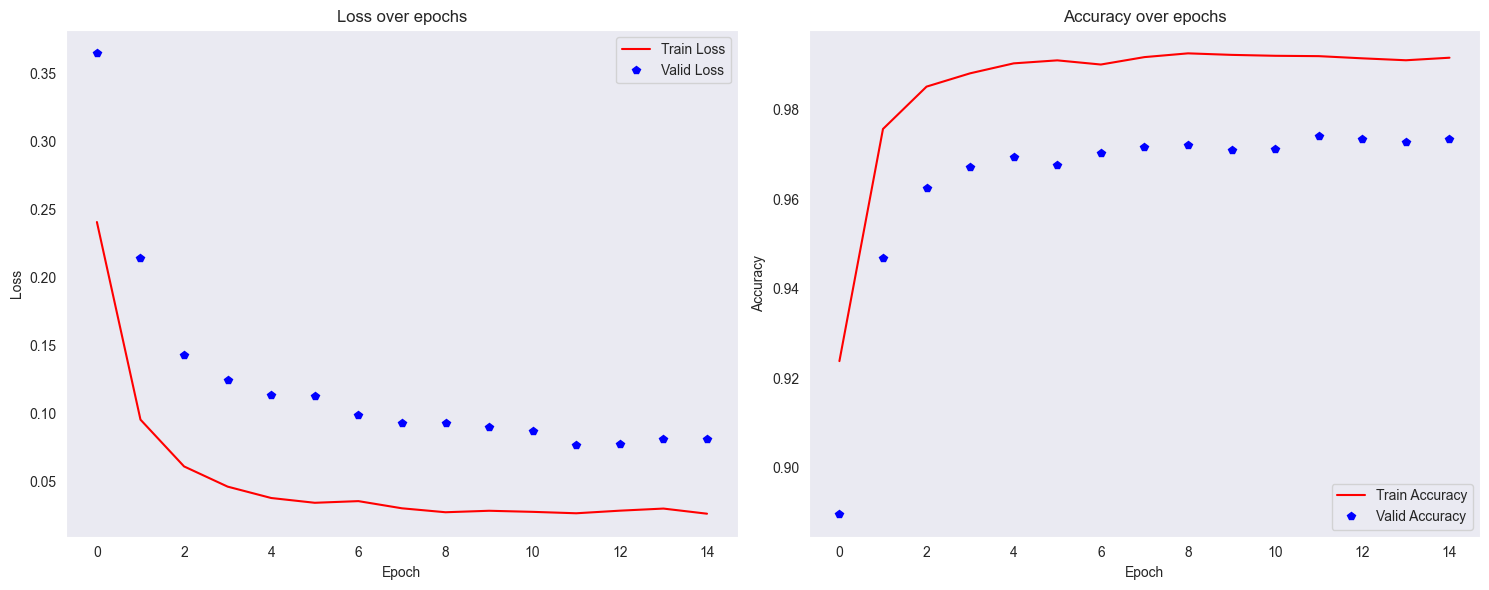

In [48]:
# Accuracies and losses
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ax[0].plot(train_losses, "r", label="Train Loss")
ax[0].plot(valid_losses, "bp", label="Valid Loss")
ax[0].set_title("Loss over epochs")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[0].grid()
ax[0].set_ylabel("Loss")

ax[1].plot(train_accuracies, "r", label="Train Accuracy")
ax[1].plot(valid_accuracies, "bp", label="Valid Accuracy")
ax[1].set_title("Accuracy over epochs")
ax[1].set_xlabel("Epoch")
ax[1].legend()
ax[1].grid()
ax[1].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()

### Interface to call the model prediction

In [49]:
def predict_email(email: str, model, vectorizer, device, top_n=5) -> dict:
    model.eval()
    time_before = time.time()

    # Vectorizing and transforming mail to a matrix
    email_csrmatrix = vectorizer.transform([email])
    email_coomatrix = email_csrmatrix.tocoo()
    indices = tensor(np.array([email_coomatrix.row, email_coomatrix.col])).cpu()
    values = tensor(email_coomatrix.data, dtype=torch.float32).cpu()
    email_tensor = torch.sparse_coo_tensor(indices, values, torch.Size(email_coomatrix.shape)).to_dense().cpu()

    with torch.no_grad():
        # Predicting and selecting important words
        outputs = model(email_tensor)
        _, prediction = torch.max(outputs, 1)

        first_layer_weights = model.layers[0].weight.data.cpu().numpy()
        suspicious_weights = first_layer_weights[1]

        word_importance = email_tensor[0].cpu() * suspicious_weights
        important_words_indices = np.argsort(word_importance)[-top_n:]

        important_words = [vectorizer.get_feature_names_out()[i] for i in important_words_indices]
        important_scores = [word_importance[i] for i in important_words_indices]

        important_scores = tensor(important_scores).softmax(dim=0)
        important_scores = [score * 100 for score in important_scores]

    time_after = time.time()
    time_taken = time_after - time_before

    confidences = torch.softmax(outputs, dim=1).cpu().numpy()
    formatted_output = {
        "is_suspicious": prediction.item(),
        "confidence": float(confidences.max()) * 100,
        "important_words": list(zip(important_words, important_scores)),
        "time_taken": time_taken,
    }
    
    return formatted_output

In [50]:
sus_mail = """Dear Customer,

To ensure the continued security of your account, we need you to update your account details. Please verify your information by October 5th, 2024 to avoid any disruption in service.

Click here to update your account:
Update Account

Thank you for helping us keep your account safe.

Best regards,
Customer Support
[Company Name]"""

ok_mail = """DEAR ALL



TO VIEW THE ANSWER SCRIPTS AND TO KNOW THE GRADES OF OS FINAL EXAM, YOU CAN VISIT MY OFFICE ON TUESDAY, 26TH DEC. 2023 FROM 10AM TO 1.30PM.

PLEASE ADHERE STRICTLY TO THE ABOVE SPECIFIED SCHEDULE.



With best regards

DR A. R. NASEER, Ph.D(IITD), M.Tech(NITK), SMIEEE, LMISTE, MIAENG ,MVSI, MCSI 
PROFESSOR, SCHOOL OF GLOBAL CONVERGENCE STUDIES(SGCS)

INHA UNIVERSITY, INCHEON, SOUTH KOREA

HEAD & PROFESSOR OF COMPUTER SCIENCE & ENGINEERING

SCHOOL OF COMPUTER AND INFORMATION ENGINEERING (SOCIE)
INHA UNIVERSITY TASHKENT, UZBEKISTAN​"""
 
answer = predict_email(sus_mail, model, vectorizer, device, top_n=10)

print(answer)

C:\Users\sqdar\AppData\Local\Temp\ipykernel_13948\3882722996.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  word_importance = email_tensor[0].cpu() * suspicious_weights


{'is_suspicious': 1, 'confidence': 91.0571277141571, 'important_words': [('zz', tensor(9.9569)), ('help', tensor(9.9596)), ('name', tensor(9.9643)), ('account', tensor(9.9810)), ('pleas', tensor(9.9901)), ('need', tensor(10.0002)), ('avoid', tensor(10.0041)), ('dear', tensor(10.0144)), ('updat', tensor(10.0472)), ('inform', tensor(10.0822))], 'time_taken': 2.2104060649871826}


Loss: 4.137692329300114e-05, Accuracy: 0.9736071380489351


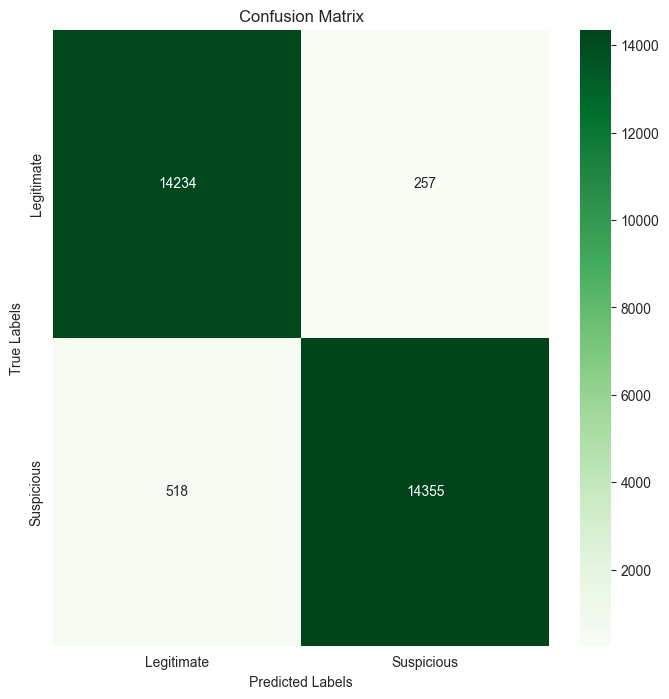


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     14491
           1       0.98      0.97      0.97     14873

    accuracy                           0.97     29364
   macro avg       0.97      0.97      0.97     29364
weighted avg       0.97      0.97      0.97     29364



In [51]:
# Model metrics evaluation
model.to(device) 
model.eval()

y_true = []
y_preds = []

total_loss, total_acc, count = 0., 0., 0.
with torch.no_grad():
    for x_batch, y_batch in test_dl:
        predictions = model(x_batch)
        loss = loss_function(predictions, y_batch.view(-1))

        count += len(x_batch)
        total_loss += loss.item()
        acc = accuracy(predictions, y_batch)
        total_acc += acc * len(x_batch)
        
        y_preds.extend(predictions.argmax(dim=1).cpu().numpy())
        y_true.extend(y_batch.view(-1).cpu().numpy()) 
        
print(f"Loss: {total_loss / count}, Accuracy: {total_acc / count}")

# Confusion Matrix and Classification Report
confusion_matrix = confusion_matrix(y_true, y_preds)
class_names = ["Legitimate", "Suspicious"]

plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_preds))
